In [2]:
# import packages needed in this analysis
from lightkurve.correctors import RegressionCorrector, DesignMatrix
import lightkurve as lk  # main package used here
from astropy.coordinates import Angle
import matplotlib.pyplot as plt  # used for plotting
import numpy as np  # used for a few needed methods
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# this function is designed to search targets from the data set
# with given target WISE ID and returns available sectors of data
def search_target(name):
    # subtract the substring with char index
    RA_Hour = name[1:3]
    RA_Min = name[3:5]
    RA_Sec = name[5:10]
    RA_String = RA_Hour+'h'+RA_Min+'m'+RA_Sec+'s'
    # obtain the hour angle with astroPy function Angle()
    RA = str(np.around(Angle(RA_String).degree, 7))

    # similar to the procedures in RA
    DEC_Degree = name[10:13]
    DEC_Min = name[13:15]
    DEC_Sec = name[15:19]
    DEC_String = DEC_Degree+'d'+DEC_Min+'m'+DEC_Sec+'s'
    DEC = np.around(Angle(DEC_String).degree, 7)
    if DEC > 0:
        DEC = '+' + str(DEC)
    else:
        DEC = str(DEC)
    targetString = RA + DEC
    print(f"Degree Coordinates of {name}: {targetString}")
    pfs = lk.search_tesscut(targetString)
    return pfs

In [181]:
# this function creates background masks based on user-specified thresholds,
# below which the pixel will be regarded as background pixel and then removed.
def create_mask(pf, threshold):
    # arbitrarily choose a frame as reference
    frame_num = 200
    # obtain the size of the target pixel file
    size = len(pf.flux[frame_num][0])
    # calculate the flux at the percentile specified by threshold
    p = np.percentile(pf.flux[frame_num], threshold)

    # initialize the background mask as all False
    background_mask = np.zeros((pf.shape[1:]), dtype='bool')
    for i in range(size):
        for j in range(size):
            # if the flux of the pixel is below the threshold, regard it as background
            if pf.flux[frame_num][i][j] <= p:
                background_mask[i, j] = True

    return background_mask

In [175]:
# this function returns one time array and one flux array combined from 
# multiple sectors with continuous observations.
def create_collection(name, sec_list, thresh=25):
    pfs = search_target(name)
    # initialize two empty arrays which then will be concatenated together
    raw_time_combined = np.array([])
    raw_flux_combined = np.array([])
    time_combined = np.array([])
    flux_combined = np.array([])
    flux_normalized = np.array([])
    # set component number as 3
    components = 3
    
    for i in sec_list:
        # download the specified sector by sector index
        pf = pfs[i].download(cutout_size=25)
        # create a mask over the target
        t_mask = np.zeros((pf.shape[1:]), dtype='bool')
        t_mask[12:14, 12:14] = True
        # convert the target pixel file into lightcurve data
        lc = pf.to_lightcurve(aperture_mask=t_mask)
        clean_lc = lc.remove_nans()

        # create a background light curve and clean it
        background_mask = create_mask(pf, threshold=thresh)
        background_mask[t_mask==True] = False
        avg_backg = avg_background(pf, background_mask)
        clean_bkd = pf.to_lightcurve(aperture_mask=background_mask).remove_nans().flux
        
        dm = DesignMatrix(clean_bkd,
                          name='regressors').pca(components).append_constant()
        rc = RegressionCorrector(clean_lc)
        rc.correct(dm)
        corrected_lc = clean_lc - rc.model_lc + np.percentile(rc.model_lc.flux, 5)
        
        # concatenate the time array and flux array of the current sector
        # to the combined lists
        raw_time_combined = np.hstack((raw_time_combined, clean_lc.time.value))
        raw_flux_combined = np.hstack((raw_flux_combined, clean_lc.flux.value))
        flux_combined = np.hstack((flux_combined, corrected_lc.flux.value))
        flux_combined = np.hstack((flux_combined, clean_bkd.value))
        flux_normalized = np.hstack((flux_normalized, corrected_lc.flux.value / avg_backg))
        
    return raw_time_combined, raw_flux_combined, time_combined, flux_combined, flux_normalized

In [91]:
# this function returns one time array and one flux array combined from
# multiple sectors with continuous observations.
def normalize_lc(name, sec_list, thresh=5):
    pfs = search_target(name)
    # initialize two empty arrays which then will be concatenated together
    time_combined = np.array([])
    flux_normalized = np.array([])

    for i in sec_list:
        # download the specified sector by sector index
        pf = pfs[i].download(cutout_size=25)
        # create a mask over the target
        t_mask = np.zeros((pf.shape[1:]), dtype='bool')
        t_mask[12:14, 12:14] = True
        # convert the target pixel file into lightcurve data
        lc = pf.to_lightcurve(aperture_mask=t_mask)

        # create a background light curve and clean it
        background_mask = create_mask(pf, threshold=thresh)
        background_mask[t_mask==True] = False
        bkg = pf.to_lightcurve(aperture_mask=background_mask)
        normalized_lc = lc / bkg
        # concatenate the time array and flux array of the current sector
        # to the combined lists
        time_combined = np.hstack((time_combined, lc.time.value))
        flux_normalized = np.hstack((flux_normalized, normalized_lc.flux.value))

    return time_combined, flux_normalized

In [141]:
def avg_background(pf, mask):
    frame_sum = np.zeros(len(pf.flux))
    for i in range(len(pf.flux)):
        frame_sum[i] = np.sum(pf.flux[i][mask==True].value)
    sec_avg = np.median(frame_sum)
    return sec_avg

In [6]:
# this function plots the lightcurve according to given x and y values,
# target name, plot title, and plot y limit.
def plot_lc(x, y, name, title, ylimit):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(14, 8)
    ax.plot(x, y, color='black')
    ax.set(xlabel='Time',
           ylabel='Flux',
           ylim = ylimit,
           title=name+' '+title)
    ax.grid(color='gray', alpha=0.4)
    plt.show()

In [171]:
# the name of the target
#target_name = 'J063207.99-681041.6'
target_name = 'J050655.47+105953.0'
# do the search
pfs = search_target(target_name)
pfs[0:12]

Degree Coordinates of J050655.47+105953.0: 76.731125+10.9980556


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 05,2018,TESScut,1426,76.731125+10.9980556,0.0
1,TESS Sector 32,2020,TESScut,475,76.731125+10.9980556,0.0


In [172]:
chosen_pf = pfs[0]
# TESS covers 21 arcseconds per pixel
pf = chosen_pf.download(cutout_size=25)

<AxesSubplot:title={'center':'Target ID: 76.731125+10.9980556, Cadence: 200'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

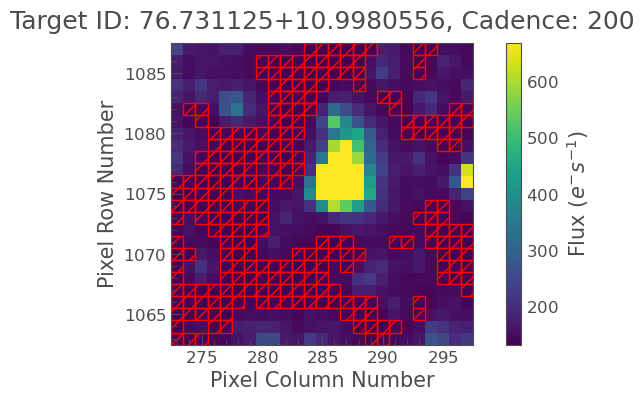

In [173]:
t_mask = np.zeros((pf.shape[1:]), dtype='bool')
t_mask[12:14, 12:14] = True

frame_num = 200
# obtain the size of the target pixel file
size = len(pf.flux[frame_num][0])
# calculate the flux at the percentile specified by threshold
p = np.percentile(pf.flux[frame_num], 40)

# initialize the background mask as all False
background_mask = np.zeros((pf.shape[1:]), dtype='bool')
for i in range(size):
    for j in range(size):
        # if the flux of the pixel is below the threshold, regard it as background
        if pf.flux[frame_num][i][j] < p:
            background_mask[i, j] = True
pf.plot(frame=frame_num, aperture_mask=background_mask)

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

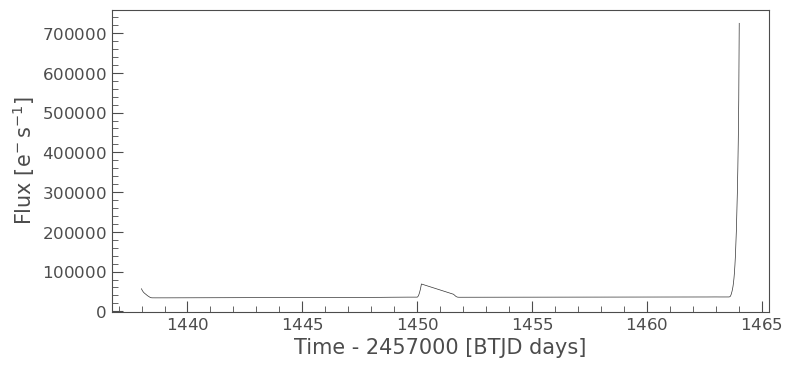

In [174]:
lc = pf.to_lightcurve(aperture_mask=background_mask)
lc.plot()

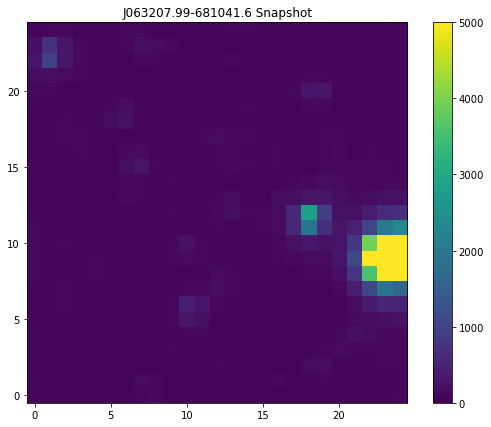

In [146]:
frame_num = 90
snapforEdit = pf.flux[frame_num].value + pf.flux_bkg[frame_num].value
plt.figure(figsize=(9, 7))
plt.imshow(snapforEdit, origin='lower', aspect='equal')
plt.colorbar()
plt.clim(0, 5000)
plt.title(target_name + ' Snapshot')
plt.show()

In [182]:
sec_list = np.array([0,1,2,3,4,5,6,7,8,9,10,11])

target_name = 'J063207.99-681041.6'  # target in the Part II paper
raw_time, raw_flux, time, flux, normalized_flux = create_collection('J063157.41-68097.7', sec_list, thresh=5)
#time, normalized_flux = normalize_lc('J050655.47+105953.0', [1], thresh=30)
#neighbor_name = 'J063215.41-681259.2'
#raw_neigh_time, raw_neigh_flux, neigh_time, neigh_flux = create_collection(neighbor_name, sec_list, thresh=50)

Degree Coordinates of J063157.41-68097.7: 97.9892083-68.1521389
32
32
32
32
32
32
32
32
32
32
32
32


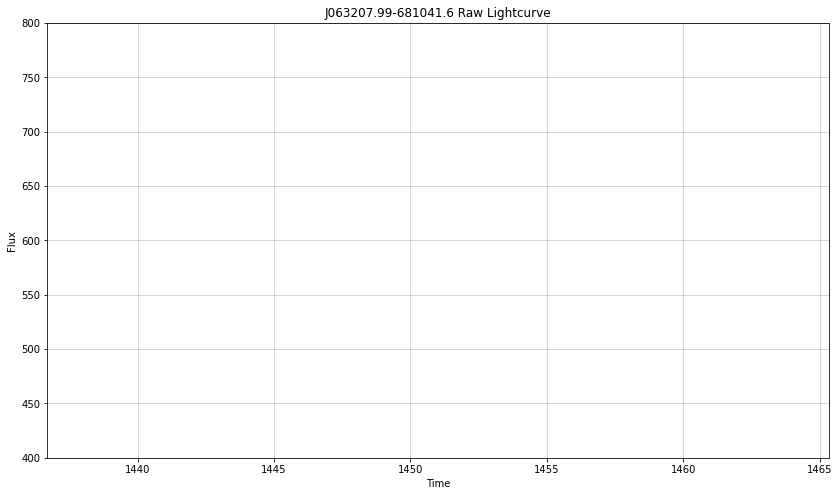

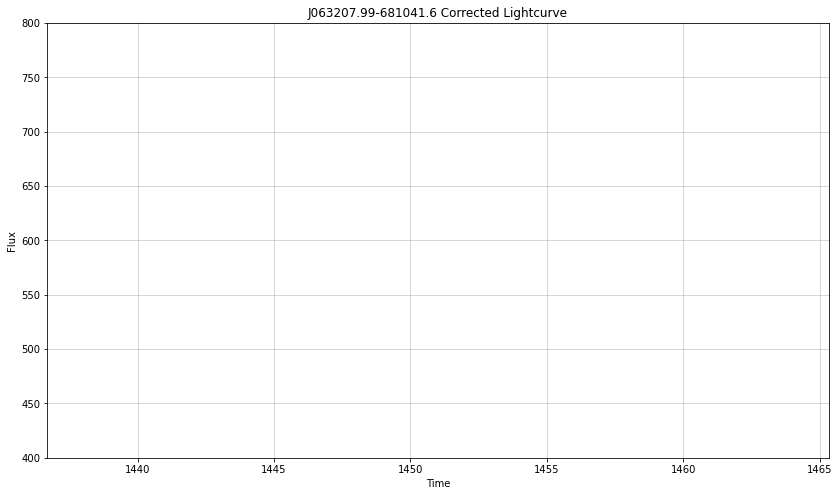

In [128]:
plot_lc(raw_time, raw_flux, target_name, 'Raw Lightcurve', ylimit=[400,800])
plot_lc(time, flux, target_name, 'Corrected Lightcurve', ylimit=[400,800])
#plot_lc(raw_neigh_time, raw_neigh_flux, neighbor_name, 'Raw Lightcurve', ylimit=[600,900])
#plot_lc(neigh_time, neigh_flux, neighbor_name,'Corrected Lightcurve', ylimit=[600,900])

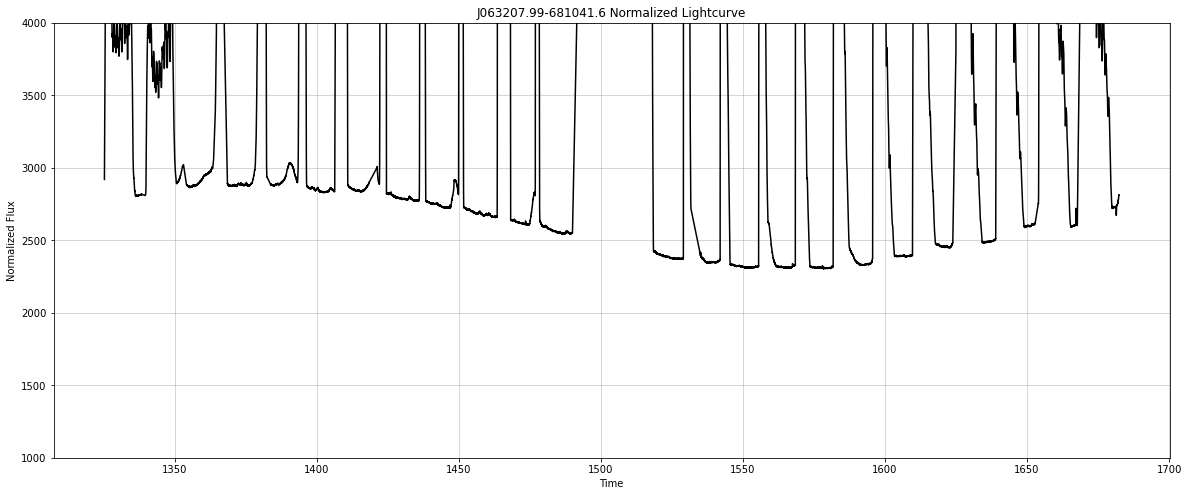

In [180]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20, 8)
ax.plot(time, flux, color='black')
ax.set(xlabel='Time', #xlim=[1400,1450],
       ylabel='Normalized Flux',
       ylim=[1000,4000],
       title=target_name+' Normalized Lightcurve')
ax.grid(color='gray', alpha=0.4)
plt.show()